# LightGBM Starter Notebook - Titanic Classification

`00_prepare_data.ipynb` で作成した Titanic の Train/Test を使い、Train側を通常のランダムsplitで学習する例

In [13]:
import os
import random
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, log_loss
import matplotlib.pyplot as plt

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [14]:
# 00_prepare_data.ipynb で保存したデータを読み込む
train_df = pd.read_csv('data/processed/classification_train.csv')
test_df = pd.read_csv('data/processed/classification_test.csv')

X_train_full = train_df.drop(columns=['target'])
y_train_full = train_df['target'].astype(int)
X_test = test_df.drop(columns=['target'])
y_test = test_df['target'].astype(int)

print(f'Train full shape: {X_train_full.shape}')
print(f'Test shape      : {X_test.shape}')
print('Train class ratio:', y_train_full.value_counts(normalize=True).sort_index().to_dict())
print('Test  class ratio:', y_test.value_counts(normalize=True).sort_index().to_dict())

Train full shape: (19536, 14)
Test shape      : (29306, 14)
Train class ratio: {0: 0.7366400491400491, 1: 0.26335995085995084}
Test  class ratio: {0: 0.7366068381901317, 1: 0.26339316180986827}


In [15]:
# Train/Valid分割（非層化ランダムsplit）
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=SEED, stratify=None
)

print(f"Train: {X_train.shape}, Valid: {X_valid.shape}, Test: {X_test.shape}")
print('Train class ratio:', y_train.value_counts(normalize=True).sort_index().to_dict())
print('Valid class ratio:', y_valid.value_counts(normalize=True).sort_index().to_dict())
print('Test  class ratio:', y_test.value_counts(normalize=True).sort_index().to_dict())

Train: (14652, 14), Valid: (4884, 14), Test: (29306, 14)
Train class ratio: {0: 0.7346437346437347, 1: 0.26535626535626533}
Valid class ratio: {0: 0.7426289926289926, 1: 0.2573710073710074}
Test  class ratio: {0: 0.7366068381901317, 1: 0.26339316180986827}


In [16]:
# モデル訓練（Validationセットで検証）
class_labels = np.sort(y_train_full.unique())
num_class = len(class_labels)

model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=num_class,
    n_estimators=120,
    learning_rate=0.05,
    num_leaves=7,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=SEED,
    bagging_seed=SEED,
    feature_fraction_seed=SEED,
    data_random_seed=SEED,
    deterministic=True,
    force_col_wise=True
)
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='multi_logloss'
 )

[LightGBM] [Info] Total Bins 839
[LightGBM] [Info] Number of data points in the train set: 14652, number of used features: 14
[LightGBM] [Info] Start training from score -0.308370
[LightGBM] [Info] Start training from score -1.326682


,boosting_type,'gbdt'
,num_leaves,7
,max_depth,-1
,learning_rate,0.05
,n_estimators,120
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [17]:
# 最終評価（Train / Valid / Test で評価）
proba_train = model.predict_proba(X_train)
proba_valid = model.predict_proba(X_valid)
proba_test = model.predict_proba(X_test)

pred_train = model.predict(X_train)
pred_valid = model.predict(X_valid)
pred_test = model.predict(X_test)

metrics_df = pd.DataFrame({
    'Split': ['Train', 'Valid', 'Test'],
    'Accuracy': [
        accuracy_score(y_train, pred_train),
        accuracy_score(y_valid, pred_valid),
        accuracy_score(y_test, pred_test),
    ],
    'F1_macro': [
        f1_score(y_train, pred_train, average='macro'),
        f1_score(y_valid, pred_valid, average='macro'),
        f1_score(y_test, pred_test, average='macro'),
    ],
    'LogLoss': [
        log_loss(y_train, proba_train, labels=class_labels),
        log_loss(y_valid, proba_valid, labels=class_labels),
        log_loss(y_test, proba_test, labels=class_labels),
    ]
})

print(metrics_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

Split  Accuracy  F1_macro  LogLoss
Train    0.8274    0.7499   0.3703
Valid    0.8266    0.7423   0.3748
 Test    0.8267    0.7479   0.3774


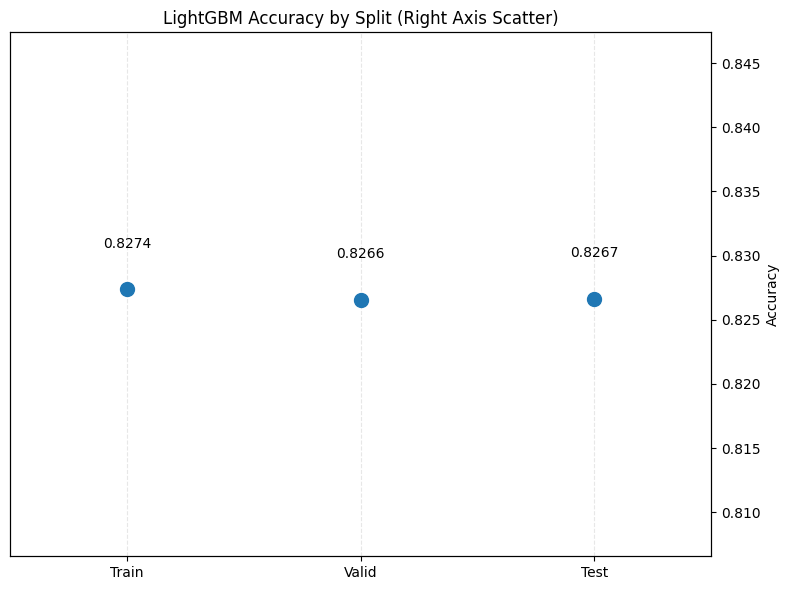

In [18]:
# Train / Valid / Test のAccuracyを右軸に散布図で表示（最終評価）
fig, ax = plt.subplots(figsize=(8, 6))
ax_right = ax.twinx()

x = np.arange(len(metrics_df))
labels = metrics_df['Split']

# 左軸は補助的に非表示（右軸にAccuracyを表示）
ax.set_xlim(-0.5, len(metrics_df) - 0.5)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_yticks([])
ax.set_ylabel('')
ax.grid(axis='x', linestyle='--', alpha=0.3)

# 右軸: Accuracy の散布図
ax_right.scatter(x, metrics_df['Accuracy'], color='tab:blue', s=100)
for i, score in enumerate(metrics_df['Accuracy']):
    ax_right.text(i, score + 0.003, f"{score:.4f}", ha='center', va='bottom', fontsize=10)

ax_right.set_ylabel('Accuracy')
ax_right.set_ylim(max(0.0, metrics_df['Accuracy'].min() - 0.02), min(1.0, metrics_df['Accuracy'].max() + 0.02))

plt.title('LightGBM Accuracy by Split (Right Axis Scatter)')
plt.tight_layout()
plt.show()